In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/done/ml_data.csv', encoding='cp949')

In [4]:
ori_y = data['단위생산량']
data['단위생산량'] = np.log1p(data['단위생산량'])
# 추후 결괏값을 expm1()으로 환원하여 실제 생산량으로!

In [5]:
random_state = 0

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
def get_rmse(model):
    from sklearn.metrics import mean_squared_error
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 4))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [8]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [9]:
def visualize_coef(models):
    fig, axs = plt.subplots(figsize=(20, 15), nrows=2, ncols=2)
    fig.tight_layout()
    
    for idx, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        row = int(idx / 2)
        col = idx % 2
        
        axs[row][col].set_title(model.__class__.__name__+'Coeffiecents', size=25)
        axs[row][col].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[row][col].get_xticklabels() + axs[row][col].get_yticklabels()):
            label.set_fontsize(20)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[row][col])

In [10]:
def print_best_params(model, params):
    from sklearn.model_selection import GridSearchCV
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} 5 CV 시 최적 평균 RMSE 값: {np.round(rmse, 4)}, 최적 alpha:{grid_model.best_params_}')

In [11]:
y = data['단위생산량']
X = data.drop(columns='단위생산량')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 결정트리

In [12]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

get_rmse(dt_reg)

DecisionTreeRegressor 로그 변환된 RMSE: 0.2313


0.23126374530463126

# SVM(Support Vector Machine)

In [14]:
from sklearn.svm import SVR

In [15]:
svr_reg = SVR()
svr_reg.fit(X_train, y_train)

get_rmse(svr_reg)

SVR 로그 변환된 RMSE: 0.1961


0.19612923122688092

# Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)

get_rmse(gb_reg)

GradientBoostingRegressor 로그 변환된 RMSE: 0.2153


0.21534076750569528

# 랜덤 포레스트

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

get_rmse(rf_reg)

RandomForestRegressor 로그 변환된 RMSE: 0.1872


0.1871971480379453

In [19]:
rf_params = {'max_depth':[8, 11, 15, 20],
             'min_samples_leaf':[8, 10, 11, 14],
             'min_samples_split':[6, 8, 10, 12, 14]
            }
best_rige = print_best_params(rf_reg, rf_params)

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값: 0.2476, 최적 alpha:{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [20]:
rf_reg = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=15, min_samples_leaf=8, min_samples_split=14, random_state=random_state)
rf_reg.fit(X_train, y_train)

get_rmse(rf_reg)

RandomForestRegressor 로그 변환된 RMSE: 0.1774


0.1773695344494525

RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=15, min_samples_leaf=8, min_samples_split=14, random_state=random_state)

<AxesSubplot:>

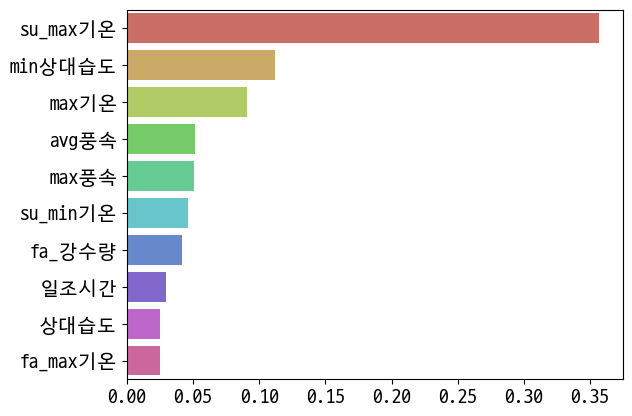

In [21]:
fi_value = rf_reg.feature_importances_
fi = pd.Series(fi_value, X.columns)
fi_top10 = fi.sort_values(ascending=False)[:10]

sns.barplot(x=fi_top10.values, y=fi_top10.index, palette='hls')

# Random Forest Regression 향후 예측

## 강원도 예측

In [22]:
X_test = pd.read_csv('data/gangwonchange.csv', encoding='cp949')

year = X_test['년']

X_test.drop(columns='년', inplace=True)

In [23]:
pred = rf_reg.predict(X_test)

In [24]:
predict = pd.DataFrame(np.expm1(pred))

predict['년'] = year

predict.columns = ['예상', '년']

predict

,예상,년
0,1240.631198,2001~2010
1,1239.735999,2021~2030
2,1442.860310,2031~2040
3,1444.648176,2041~2050
4,1497.459342,2051~2060
5,1517.567965,2061~2070
6,1517.567965,2071~2080
7,1519.756716,2081~2090
8,1626.841117,2091~2100


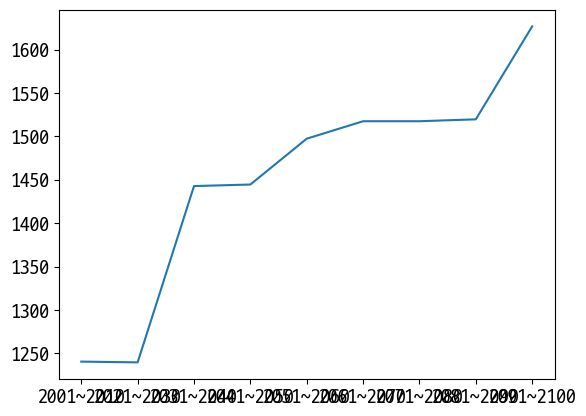

In [25]:
plt.plot(predict['년'], predict['예상'])

In [26]:
predict.to_csv('data/predict/gangwon_rf.csv', encoding='cp949', index=False)

## 충남 예측

In [27]:
X_test = pd.read_csv('data/chungnamchange.csv', encoding='cp949')

year = X_test['년']

X_test.drop(columns='년', inplace=True)

In [28]:
pred = rf_reg.predict(X_test)

In [29]:
predict = pd.DataFrame(np.expm1(pred))

predict['년'] = year

predict.columns = ['예상', '년']

predict

,예상,년
0,1606.774194,2001~2010
1,1608.186299,2021~2030
2,1616.516813,2031~2040
3,1621.095996,2041~2050
4,1621.298439,2051~2060
5,1624.025053,2061~2070
6,1614.023105,2071~2080
7,1610.739872,2081~2090
8,1612.121914,2091~2100


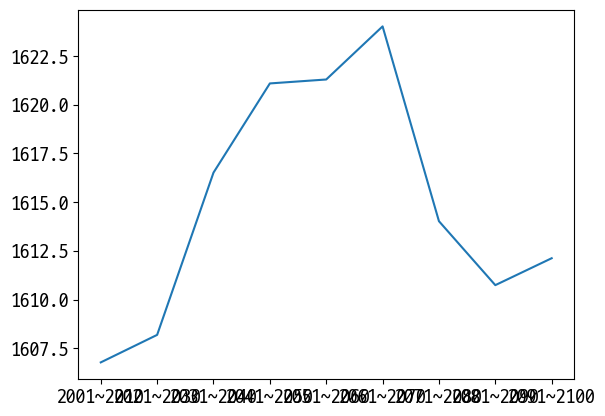

In [30]:
plt.plot(predict['년'], predict['예상'])

In [31]:
predict.to_csv('data/predict/chungnam_rf.csv', encoding='cp949', index=False)

## 경북 예측

In [32]:
X_test = pd.read_csv('data/gyeongbukchange.csv', encoding='cp949')

year = X_test['년']

X_test.drop(columns='년', inplace=True)

In [33]:
pred = rf_reg.predict(X_test)

In [34]:
predict = pd.DataFrame(np.expm1(pred))

predict['년'] = year

predict.columns = ['예상', '년']

predict

,예상,년
0,1641.701777,2001~2010
1,1599.139090,2021~2030
2,1637.177445,2031~2040
3,1643.225390,2041~2050
4,1654.240270,2051~2060
5,1667.997195,2061~2070
6,1673.785108,2071~2080
7,1653.611335,2081~2090
8,1638.470393,2091~2100


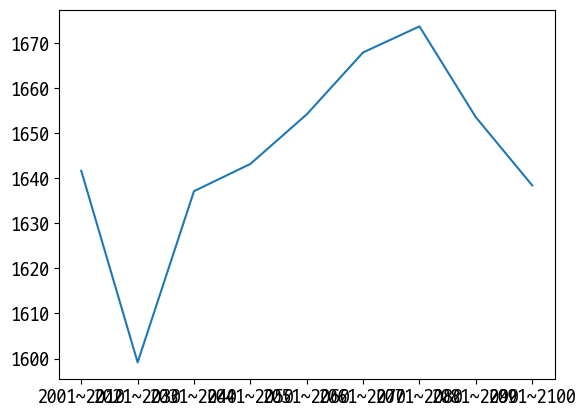

In [35]:
plt.plot(predict['년'], predict['예상'])

In [36]:
predict.to_csv('data/predict/gyeongbuk_rf.csv', encoding='cp949', index=False)